# Necessary Imports & Setup

In [3]:
!pip install matplotlib

In [4]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('trifinger_rl_datasets'))
sys.path.insert(0, module_path)
module_path = os.path.abspath(os.path.join('trifinger-rl-example'))
sys.path.insert(0, module_path)
module_path = os.path.abspath(os.path.join('google-research'))
sys.path.insert(0, module_path)

In [5]:
import trifinger_rl_datasets
import gymnasium as gym

# set torch an numpy seed
import numpy as np
import tensorflow as tf
import torch

pybullet build time: May 20 2022 19:44:17
2023-07-07 06:45:41.980693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 06:45:42.821558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
# this can be changed to any other environment in the trifinger gym
# see https://webdav.tuebingen.mpg.de/trifinger-rl/docs/datasets/index.html
# However, if real robot data is used, no monte carlo sampling is possible 
# Since real-env does not support simulation
env_name = "trifinger-cube-push-sim-mixed-v0"
normalize_states = True
normalize_rewards = True
seed = 0

# this noise is applied to the rewards, there is a seperate paper 
# on this improving the performance https://arxiv.org/pdf/2007.13609.pdf
noise_scale = 0.0 
bootstrap = False # use bootstraped weights
sample_batch_size = 256


np.random.seed(seed)
torch.manual_seed(seed)
tf.random.set_seed(seed)

Below the process is restricted to using 20% of available GPU memory, otherwise it uses all due to prefetching the huge dataset.

If limited to 20% we can launch multiple tf runs in parallel.

In [7]:

gpu_memory = 12209 # GPU memory available on the machine
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Restrict TensorFlow to only allocate 20% of the memory on the first GPU
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(gpu_memory * 0.2))])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e, " GPUs must be set at program startup")



1 Physical GPUs, 1 Logical GPUs


2023-07-07 06:45:50.031132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2441 MB memory:  -> device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2


# Create Gym env

In [8]:
env = gym.make(
    "trifinger-cube-push-sim-mixed-v0",
    set_terminals =True,  # necessary since DOPE uses the terminals
    flatten_obs = True,   # obs as dictionary vs as array  
    image_obs = False,    # deactivate fetching images since large amounts of data
    visualization=False,  # enable visualization
)
dataset = env.get_dataset() # pull the dataset
dataset.keys()

/envs/eval/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.66s/it]


Assembling dataset parts.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


dict_keys(['observations', 'actions', 'rewards', 'timeouts', 'terminals', 'infos'])

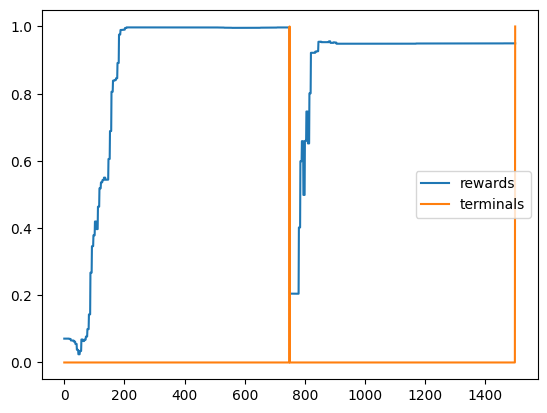

In [9]:
# you can plot data here e.g.
import matplotlib.pyplot as plt
# the rewards are a flattened array and each episode is 750 steps
plt.plot(dataset["rewards"][:750*2]) 
plt.plot(dataset["terminals"][:750*2])
# add legend
plt.legend(["rewards", "terminals"])
plt.show()

# Monte Carlo Rollouts


Load the policy, set num_mc_episodes= 1 such that it works faster!

In [10]:
from trifinger_rl_datasets import PolicyBase
from trifinger_rl_datasets.evaluate_sim import load_policy_class
import typing
import tqdm

In [11]:
# this is the expert policy, you can also use the random policy
# policy_class = "trifinger_rl_example.example.TorchRandomPolicy"
policy_class = "trifinger_rl_example.example.TorchPushPolicy" 
discount = 0.995
monte_carlo = False
num_mc_episodes = 50 # Monte carlo roll-outs, set this to 1 if not wanting to wait!

In [12]:
Policy = load_policy_class(policy_class)
policy_config = Policy.get_policy_config()
print(policy_config)
assert(policy_config.flatten_obs == True)
assert(policy_config.image_obs == False)
actor = Policy(env.action_space, env.observation_space, env.sim_env.episode_length)

PolicyConfig(flatten_obs=True, image_obs=False)
/app/ws/trifinger-rl-example/trifinger_rl_example/policies/push.pt


The `TrifingerActor` class can be: 

1) called with actions, in this case it returns the logprob of these actions under the observations and a standard deviation. 
2) called with actions=None, in this case it returns the deterministic actions yielded by the policy network wrt to the observations. If noisy=True the actor uses the actions yielded by the policy as the mean of a normal distribution that is sampled to return the actions.

In [13]:

class TrifingerActor(object):
  def __init__(self, actor, noisy= False):
      self.actor = actor
      # self.std = std
      self.noisy = noisy

  def reset(self):
      self.actor.reset()

  def __call__(self, obs, std= 0.05, actions=None):
      self.std = std
      # assert that if noisy std > 0 
      assert(self.noisy == False or self.std > 0)
      if len(obs.shape) == 1:
          obs = np.expand_dims(obs, axis=0)
          
      obs = torch.from_numpy(obs)
      action = None
      log_prob = None
      action_mean = self.actor.policy(obs)

      if actions is None: 
          if self.noisy:
              # print the action mean and std
              # print(action_mean) # , self.std)
              normal = torch.distributions.Normal(action_mean, self.std)
              action = normal.sample()
              action = torch.clamp(action,torch.tensor(env.action_space.low), torch.tensor(env.action_space.high))
              action = action.detach().numpy()
              # print the sampled action
              # print(action)
          else:
              action = action_mean.detach().numpy()
      else:
          actions = torch.from_numpy(actions)
          normal = torch.distributions.Normal(action_mean, self.std)
          actions = torch.clamp(actions,torch.tensor(env.action_space.low),  torch.tensor(env.action_space.high))
          log_prob = normal.log_prob(actions)
          log_prob = log_prob.detach().numpy()
          action = None
      return None, action, log_prob

In [14]:
actor_wrap = TrifingerActor(actor, noisy= True)
dummy_input = np.random.randn( env.observation_space.shape[0])
print(dummy_input.shape)
_, actions, _ = actor_wrap(dummy_input, std=0.05)
print(f"actions (std=0.05): {actions}")
_,_,log_probs = actor_wrap(dummy_input,actions=actions) 
print(f"log_probs (std=0.05): {log_probs}")
_, actions, _ = actor_wrap(dummy_input, std= 0.2)
print(f"actions (std=0.2): {actions}")
_,_,log_probs = actor_wrap(dummy_input,actions=actions) 
print(f"log_probs (std=0.2): {log_probs}")

(97,)
actions (std=0.05): [[-0.02843939 -0.12645188 -0.28435194 -0.36857846 -0.18905129 -0.24842718
  -0.18360354  0.397       0.11880803]]
log_probs (std=0.05): [[ 0.88945925  2.0337434  -0.29676688  1.9152368   1.4886996   1.098759
   1.9954494   2.0767937   1.818128  ]]
actions (std=0.2): [[-0.18615791 -0.2311075  -0.13900518 -0.397       0.08529566 -0.3927349
  -0.17923063  0.28373653  0.22939384]]
log_probs (std=0.2): [[ 0.7753055  -0.77099574  1.8116955   2.0767937  -7.613842   -7.102746
   1.956349   -0.4889294   0.96307755]]


A single MC episode:

In [15]:
def run_episode(
        initial_obs: dict, initial_info: dict, actor: TrifingerActor, 
        env: gym.Env, discount: float, std: float = 0.05
    ):
    """Run one episode."""
    obs = initial_obs
    info = initial_info
    actor.reset() # reset the actor
    t = 0
    rewards = []
    episode_return = 0
    infos = []
    # print(actor.noisy)
    while True:
        _, action,_ = actor(obs, std=std)
        # print the action[0]
        # print(action[0])
        obs, rew, _, truncated, info = env.step(action[0])
        # if want to normalize the rewards
        # rew_norm = behavior_dataset.normalize_rewards([rew])[0] 
        infos.append(info)
        episode_return += rew * (discount**t)
        # rewards.append(rew_norm)
        t += 1
        if truncated: # should only be called @ t==750, actually it is at 748
            
            #if info["has_achieved"]:
            #    print("Success: Goal achieved at end of episode.")
            #else:
            #    print("Goal not reached at the end of the episode.")
            break
            
    return episode_return, None, infos

In [16]:
enable_plot = False
def estimate_monte_carlo_returns(env,
                                 discount,
                                 actor,
                                 std,
                                 num_episodes,
                                 max_length = 1000):
    """Estimate policy returns using with Monte Carlo."""
    # we reset after each episode
    episode_return_sum = 0
    eps = []
    infos = []
    _reset_time = 500
    pbar = tqdm.tqdm(range(num_episodes), desc='Running Monte Carlo')
    i = 0
    for i in pbar:

        # actually the env.reset() is only reset every 8 episodes 
        # in the original code, there is a soft reset otherwise (see below)

        if i%8 == 0:
            inital_obs, inital_info = env.reset()
        ep_return, rewards, info = run_episode(inital_obs, inital_info, actor, env, discount, std=std)
        # calculate discounted returns
        episode_return_sum += ep_return
        eps.append(ep_return)
        infos.append(info)
        # caluclate std of eps
        # pbar.set_postfix({'std:': np.std(eps)*(1 - discount)})
        pbar.set_postfix({'mean:': np.mean(eps)* (1 - discount)})
        # plot in this loop the rewards
        # plot the first 750 rewards
        if enable_plot:
            plt.plot(rewards[:750])
            plt.show()

        # start soft-reset
        # move fingers to initial position and wait until cube has settled down
        env.reset_fingers(_reset_time) # as in original code
        if i < num_episodes - 1:
            # retrieve cube from barrier and center it approximately
            env.sim_env.reset_cube()
        # Sample new goal
        env.sim_env.sample_new_goal()
        initial_obs, initial_info = env.reset_fingers(_reset_time)
        # print("finished soft reset")

    return episode_return_sum / num_episodes * (1 - discount) , eps, infos

In [18]:
import pickle as pkl
print(monte_carlo)

False


In [19]:
if monte_carlo:
    actor_wrap = TrifingerActor(actor, noisy = True)
    target_policy_std = 0.05
    ep_stats, rewards, infos = estimate_monte_carlo_returns(env, discount, actor_wrap,target_policy_std, num_mc_episodes)
    # save the array rewards
    with open('noisy_05.pkl', 'wb') as f:
        pkl.dump(rewards, f)
        # save the ep_stats into the same file
        pkl.dump(ep_stats, f)
        pkl.dump(infos, f)
else:
    # load the rewards
    with open('noisy_05.pkl', 'rb') as f:
        rewards = pkl.load(f)
        ep_stats = pkl.load(f)
        infos = pkl.load(f)

In [20]:
if monte_carlo:
    actor_wrap = TrifingerActor(actor, noisy = True)
    target_policy_std = 0.2
    ep_stats_high_var, rewards_high_var, infos_high_var = estimate_monte_carlo_returns(env, discount, actor_wrap,target_policy_std, num_mc_episodes)
        # save the array rewards
    with open('noisy_2.pkl', 'wb') as f:
        pkl.dump(rewards_high_var, f)
        pkl.dump(ep_stats_high_var, f)
        pkl.dump(infos_high_var, f)
else:
    with open('noisy_2.pkl', 'rb') as f:
        rewards_high_var = pkl.load(f)
        ep_stats_high_var = pkl.load(f)
        infos_high_var = pkl.load(f)

In [21]:
if monte_carlo:
    target_policy_std = 0.0
    # actor with no noise
    actor_wrap = TrifingerActor(actor, noisy = False)
    ep_stats_no_noise, rewards_no_noise, infos_no_noise = estimate_monte_carlo_returns(env, discount, actor_wrap,target_policy_std, num_mc_episodes)
    # save the array rewards
    with open('no_noise.pkl', 'wb') as f:
        pkl.dump(rewards_no_noise, f)
        pkl.dump(ep_stats_no_noise, f)
        pkl.dump(infos_no_noise, f)
else:
    with open('no_noise.pkl', 'rb') as f:
        rewards_no_noise = pkl.load(f)
        ep_stats_no_noise = pkl.load(f)
        infos_no_noise = pkl.load(f)

Analysis of the mc rollouts with the different actors

In line with the evaluation script of Trifinger, we only count something as a success if it has achieved the goal in the last step

In [22]:
def count_successes(infos):
    successes = 0
    for i in range(len(infos)):
        if infos[i][len(infos[i])-1]["has_achieved"]==True:
            successes += 1
    return successes
            
print(f"successes with low variance:  {count_successes(infos)}/{num_mc_episodes}")
print(f"successes with high variance: {count_successes(infos_high_var)}/{num_mc_episodes}")
print(f"successes with no noise: {count_successes(infos_no_noise)}/{num_mc_episodes}")


successes with low variance:  48/50
successes with high variance: 24/50
successes with no noise: 48/50


In [23]:
# caluclate std of the rewards of each epsiode
def calculate_std(rewards):
    discounted = np.asarray(rewards)*(1-discount) # normalize the rewards (as in eps stats)
    # print(np.mean(discounted))
    if num_mc_episodes == 1:
        return 0.2
    return np.std(discounted)

std = calculate_std(rewards)
std_high_var = calculate_std(rewards_high_var)
std_no_noise = calculate_std(rewards_no_noise)

In [24]:
rewards = np.asarray(rewards)*(1-discount)
rewards_high_var = np.asarray(rewards_high_var)*(1-discount)
rewards_no_noise = np.asarray(rewards_no_noise)*(1-discount)

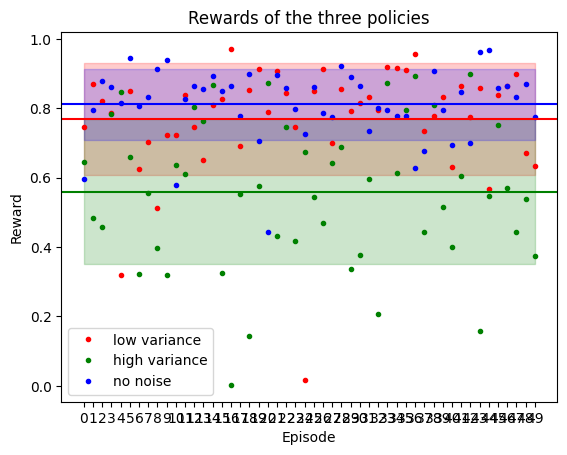

In [25]:
# plot the rewards of the two policies, with discrete points
plt.plot(rewards, 'r.', label='low variance')
plt.plot(rewards_high_var, 'g.', label='high variance')
plt.plot(rewards_no_noise, 'b.', label='no noise')
# add a line for the mean and add the std deviation as a shaded area

plt.axhline(y=ep_stats, color='r', linestyle='-')
plt.axhline(y=ep_stats_high_var, color='g', linestyle='-')
plt.axhline(y=ep_stats_no_noise, color='b', linestyle='-')
# add the shaded std deviation around the mean
plt.fill_between(range(len(rewards)), ep_stats - std, ep_stats + std, color='r', alpha=0.2)
plt.fill_between(range(len(rewards_high_var)),ep_stats_high_var - std_high_var, ep_stats_high_var + std_high_var, color='g', alpha=0.2)
plt.fill_between(range(len(rewards_no_noise)), ep_stats_no_noise - std_no_noise, ep_stats_no_noise + std_no_noise, color='b', alpha=0.2)
# add legend
plt.legend()
# add title
plt.title("Rewards of the three policies")
# add axis labels
# make the x axis discrete
plt.xticks(range(len(rewards)))
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()


# Transform/Normalize the offline RL dataset

In [26]:
import importlib
import policy_eval.dataset
importlib.reload(policy_eval.dataset)
from policy_eval.dataset import D4rlDataset

In [27]:
%%capture
# normalizing the dataset
from policy_eval.dataset import D4rlDataset
behavior_dataset = D4rlDataset(
    env,
    normalize_states=normalize_states, # True
    normalize_rewards=normalize_rewards, # True
    noise_scale=noise_scale, # is 0, adds noise to the rewards
    bootstrap=bootstrap) # is False

In [29]:
tf_dataset = behavior_dataset.with_uniform_sampling(sample_batch_size)
tf_dataset_iter = iter(tf_dataset)
# can start sampling from the newly normalized dataset
(states, actions, next_states, rewards, masks, weights,
    _) = next(tf_dataset_iter)

2023-07-04 12:23:48.474535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype float and shape [2880000]
	 [[{{node Placeholder/_4}}]]
2023-07-04 12:23:58.583130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2231645 of 2880000
2023-07-04 12:24:01.482440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


# Setup the OPE methods

In [61]:
from policy_eval import utils
from policy_eval.q_fitter import QFitter
algo = 'fqe'
lr, weight_decay, tau = 3e-5, 1e-5, 0.005 # as in paper

if algo == 'fqe':
    model = QFitter(env.action_space.shape[0],
                    env.observation_space.shape[0], lr, weight_decay,
                    tau)

/envs/eval/lib/python3.8/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


These functions are handed to the OPE methods


In [62]:
target_policy_std = 0.2
target_policy_noise = True
actor_wrap = TrifingerActor(actor, noisy = target_policy_noise)
if actor_wrap.noisy:
    print("actor is noisy")
else:
    print("actor is not noisy")

actor is noisy


In [63]:
min_reward = tf.reduce_min(behavior_dataset.rewards)
max_reward = tf.reduce_max(behavior_dataset.rewards)
min_state = tf.reduce_min(behavior_dataset.states, 0)
max_state = tf.reduce_max(behavior_dataset.states, 0)

In [64]:
# these functions are handed to the OPE methods
def get_target_actions(states):
    # now we need to offload to cpu and to numpy
    states_unnorm = behavior_dataset.unnormalize_states(states)
    # to numpy
    states_unnorm = states_unnorm.numpy()
    actions = actor_wrap(
        states_unnorm,
        std=target_policy_std)[1]
    # convert actions to tf
    #print(actions.shape)
    actions = tf.convert_to_tensor(actions)
    return actions
def get_target_logprobs(states, actions):
    states_unnorm = behavior_dataset.unnormalize_states(states)
    # to numpy
    states_unnorm = states_unnorm.numpy()
    actions = actions.numpy()
    log_probs = actor_wrap(
        states_unnorm,
        actions=actions,
        std=target_policy_std)[2]
    if tf.rank(log_probs) > 1:
        log_probs = tf.reduce_sum(log_probs, -1)
    # to tf
    log_probs = tf.convert_to_tensor(log_probs)
    return log_probs
def update_step():
    (states, actions, next_states, rewards, masks, weights,
        _) = next(tf_dataset_iter)
    initial_actions = get_target_actions(behavior_dataset.initial_states)
    next_actions = get_target_actions(next_states)

    model.update(states, actions, next_states, next_actions, rewards, masks,
        weights, discount, min_reward, max_reward)

# Train the Model

In [65]:
num_updates = 200_000
pbar = tqdm.tqdm(range(num_updates), desc='Running Training')

for i in pbar:
    update_step()

    if i % 100 == 0:
        inital_actions = get_target_actions(behavior_dataset.initial_states)
        preds = model(behavior_dataset.initial_states, inital_actions)
        pred_returns = (tf.reduce_sum(preds * behavior_dataset.initial_weights) /
                tf.reduce_sum(behavior_dataset.initial_weights))
        
        # Update the progress bar with the return value
        pred_returns = behavior_dataset.unnormalize_rewards(pred_returns)
        pbar.set_postfix({'pred_returns': pred_returns.numpy()})
    # every 10000 iterations, save the pred_results to a file
    # this is just lazy, did not setup a proper logging for this demo
    if i % 1000 == 0:
        if i == 0:
            print(f"saving to file: {env_name};noise={target_policy_noise}_2.txt")
        with open(f"{env_name};noise={target_policy_noise}_2.txt", "a") as f:

            f.write(str(pred_returns.numpy()))
            f.write("\n")

Running Training:   0%| | 0/200000 [00:00<?,

Running Training:   0%| | 8/200000 [00:00<3:

saving to file: trifinger-cube-push-sim-mixed-v0;noise=True_2.txt


Running Training:  22%|▏| 44772/200000 [10:4

In [57]:
print(noise)

['-0.013416738\n', '0.004083692\n', '0.010940096\n', '0.019735934\n', '0.028816314\n', '0.0397472\n', '0.05221284\n', '0.06535485\n', '0.07546671\n', '0.087591134\n', '0.100145444\n', '0.11163819\n', '0.12397807\n', '0.13780011\n', '0.14826275\n', '0.1614019\n', '0.1763142\n', '0.18889523\n', '0.20057498\n', '0.21003753\n', '0.22177517\n', '0.23522308\n', '0.24625672\n', '0.25636643\n', '0.26771635\n', '0.27595118\n', '0.28625298\n', '0.29865378\n', '0.30443975\n', '0.31285694\n', '0.3255699\n', '0.33275637\n', '0.33908486\n', '0.34695047\n', '0.35479805\n', '0.36461076\n', '0.36934772\n', '0.3796635\n', '0.38843706\n', '0.39329842\n', '0.3981438\n', '0.4058117\n', '0.41186687\n', '0.4169156\n', '0.42436036\n', '0.43103263\n', '0.44117078\n', '0.44659835\n', '0.45322356\n', '0.45797703\n', '0.4622106\n', '0.47106168\n', '0.4757957\n', '0.4811433\n', '0.48900932\n', '0.49002776\n', '0.49305868\n', '0.49806207\n', '0.5015952\n', '0.5070826\n', '0.51261586\n', '0.5145211\n', '0.5190751\n'

In [11]:
# plot the env_name once with noise and once without noise
with open("trifinger-cube-push-sim-mixed-v0;noise=True_2.txt") as f:
    noise = f.readlines()
with open("trifinger-cube-push-sim-mixed-v0;noise=False.txt") as f:
    no_noise = f.readlines()

# convert the strings to numpy arrays contains \n 
print(len(noise))
print(len(no_noise))
data_points = max(len(noise), len(no_noise))
noisy = np.array([noise[i].strip() for i in range(len(noise))])
noisy = noisy.astype(np.float32)
expert = np.array([no_noise[i].strip() for i in range(len(no_noise))])
expert = expert.astype(np.float32)


200
207


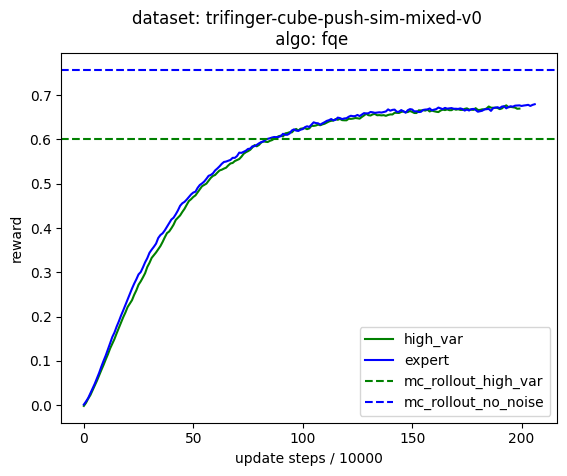

In [13]:
# plot the results with the arrays the x value and evenly spaced y values
plt.plot(noisy, label='high_var', color='g')
plt.plot(expert, label='expert', color='b')
# same color as expert line but doted


plt.axhline(y=ep_stats_high_var, color='g', linestyle='--', label = 'mc_rollout_high_var')
plt.axhline(y=ep_stats_no_noise, color='b', linestyle='--', label = 'mc_rollout_no_noise')
# add the shaded std deviation around the mean
#plt.fill_between(range(data_points), ep_stats_high_var - std_high_var, ep_stats_high_var + std_high_var, color='g', alpha=0.2)
#plt.fill_between(range(data_points), ep_stats_no_noise - std_no_noise, ep_stats_no_noise + std_no_noise, color='b', alpha=0.2)
plt.title('dataset: trifinger-cube-push-sim-mixed-v0 \n algo: fqe')
plt.xlabel('update steps / 10000')
plt.ylabel('reward')
plt.legend()
plt.show()
